In [2]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import joblib
import datetime as dt

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.models as models

#from skimage import io
import sklearn
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, f1_score, confusion_matrix, classification_report
from sklearn import metrics, preprocessing
from scipy.ndimage import zoom
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import albumentations as A
import albumentations.pytorch
import wandb

#### Hyper Param Setting

In [3]:
CFG = {
    'fold_num': 5,
    'seed': 42,
    'model': 'resnet152',
    'img_size': 260,
    'epochs': 200,
    'train_bs':64,
    'valid_bs':64,
    'lr': 1e-4, ## learning rate
    'num_workers': 8,
    'verbose_step': 1,
    'patience' : 5,
    'label_encoder':True,
    'device': 'cuda:0',
    'freezing': False,
    'trainable_layer': 12,
    'model_path': './models'
}

#### wandb init

In [4]:
category = '19_classes'
time_now = dt.datetime.now()
run_id = time_now.strftime("%Y%m%d%H%M")
project_name = 'KD_'+ CFG['model'] + '_' + category
user = 'hojunking'
run_name = project_name + '_' + run_id

In [7]:
# Data split
main_path = '../Data/carbon_reduction_data/train/'
label_list = ["10Kwalk","battery",'box','else','toothcup', 'tumbler','handkerchief',
              'milk', 'paper', 'pet','plug','receipt', 'shopping bag', 'stairs',
             'transportation', 'trash picking', 'green dish','leftover','wrap']

train_img_paths = []
train_img_labels = []

for label in label_list: ## 각 레이블 돌기
    print(f'label: {label}',end=' ')
    img_paths = [] 
    img_labels = []

    dir_path = main_path + label ## 레이블 폴더 경로
    
    for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색
        for img in filenames: ## 각 파일 경로, 레이블 저장
            img_paths.append(folder+'/'+img)
            img_labels.append(label)
        
    print(len(img_paths))

    train_img_paths.extend(img_paths)
    train_img_labels.extend(img_labels)

print('Train_Images: ',len(train_img_paths))
print("Train_Images_labels:", len(train_img_labels))

label: 10Kwalk 1173
label: battery 1683
label: box 4725
label: else 2270
label: toothcup 1684
label: tumbler 2007
label: handkerchief 1459
label: milk 1425
label: paper 999
label: pet 4159
label: plug 1758
label: receipt 505
label: shopping bag 1027
label: stairs 2436
label: transportation 1341
label: trash picking 976
label: green dish 1009
label: leftover 1186
label: wrap 1013
Train_Images:  32835
Train_Images_labels: 32835


In [9]:
## Pandas 데이터프레임 만들기
trn_df = pd.DataFrame(train_img_paths, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = train_img_labels
train = trn_df
train

,image_id,dir,label
0,0720.jpg,../Data/carbon_reduction_data/train/10Kwalk,10Kwalk
1,0282.jpg,../Data/carbon_reduction_data/train/10Kwalk,10Kwalk
2,1028.jpg,../Data/carbon_reduction_data/train/10Kwalk,10Kwalk
3,0540.jpg,../Data/carbon_reduction_data/train/10Kwalk,10Kwalk
4,0466.jpg,../Data/carbon_reduction_data/train/10Kwalk,10Kwalk
...,...,...,...
32830,0515.jpg,../Data/carbon_reduction_data/train/wrap,wrap
32831,0011.jpg,../Data/carbon_reduction_data/train/wrap,wrap
32832,0868.jpg,../Data/carbon_reduction_data/train/wrap,wrap
32833,0611.jpg,../Data/carbon_reduction_data/train/wrap,wrap


##### Label Encoding

In [10]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'].values)
train

,image_id,dir,label
0,0720.jpg,../Data/carbon_reduction_data/train/10Kwalk,0
1,0282.jpg,../Data/carbon_reduction_data/train/10Kwalk,0
2,1028.jpg,../Data/carbon_reduction_data/train/10Kwalk,0
3,0540.jpg,../Data/carbon_reduction_data/train/10Kwalk,0
4,0466.jpg,../Data/carbon_reduction_data/train/10Kwalk,0
...,...,...,...
32830,0515.jpg,../Data/carbon_reduction_data/train/wrap,18
32831,0011.jpg,../Data/carbon_reduction_data/train/wrap,18
32832,0868.jpg,../Data/carbon_reduction_data/train/wrap,18
32833,0611.jpg,../Data/carbon_reduction_data/train/wrap,18


In [11]:
def label_encoding_classes():
    # define certain classes to transform differently
    capture_image_classes = ['10Kwalk', 'battery','receipt']
    return le.transform(capture_image_classes)

In [12]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [13]:
def get_img(path, sub_path=None):
    try:
        im_bgr = cv2.imread(path)
        im_rgb = im_bgr[:, :, ::-1]
        past_path = path
    except: ## 이미지 에러 발생 시 백지로 대체
        im_bgr = cv2.imread('../Data/carbon_reduction/temp_img.jpg')
        im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

In [14]:
transform_train = A.Compose([
    A.RandomResizedCrop(p=1, height=CFG['img_size'] ,width=CFG['img_size'], scale=(0.65, 0.75),ratio=(0.90, 1.10)),
    A.HorizontalFlip(p=0.5),
    A.SafeRotate(p=0.5, limit=(-20, 20), interpolation=2, border_mode=0, value=(0, 0, 0), mask_value=None),
    A.ColorJitter(always_apply=True, p=0.5, contrast=0.2, saturation=0.3, hue=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True, p=1.0),
    A.pytorch.transforms.ToTensorV2()
        ])

transform_train_cap = A.Compose([
    A.RandomResizedCrop(p=1, height=CFG['img_size'] ,width=CFG['img_size'], scale=(0.65, 0.85),ratio=(0.90, 1.10)),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True, p=1.0),
    A.pytorch.transforms.ToTensorV2()
])

transform_test = A.Compose([
    A.Resize(height = CFG['img_size'], width = CFG['img_size']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
    A.pytorch.transforms.ToTensorV2()
        ])

In [15]:
class CustomDataset(Dataset):
    def __init__(self, df, data_root, transform=None, transform2=None, output_label=True, encoded_class=None):
        super(CustomDataset,self).__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transform = transform
        self.transform2 = transform2
        self.data_root = data_root
        self.output_label = output_label
         
        if encoded_class == True:
            print('test')
            self.encoded_class = label_encoding_classes()
        else:
            self.encoded_class = encoded_class
            
        if output_label == True:
            self.labels = self.df['label'].values
        
    # AUGMENTATION DIFFERENTLY DEPENDING ON THE TARGET
    def custom_augmentation(self, img, target):
        if self.encoded_class is not None and target in self.encoded_class:
            return self.transform2(image=img)
        else:
            return self.transform(image=img)
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # GET IMAGES
        path = "{}/{}".format(self.data_root[index], self.df.iloc[index]['image_id'])
        img  = get_img(path)
        
        # GET LABELS
        if self.output_label:
            target = self.labels[index]
            
            # CUSTOM AUGMENTATION
            transformed = self.custom_augmentation(img, target) 
            img = transformed['image']
            return img, target
        else:
            transformed =self.transform(image=img)
            img = transformed['image']
            return img

In [16]:
# LOAD PRE-TRAINED MODEL
class Teacher(nn.Module):
    def __init__(self, model_arch_str, num_classes= 2,pretrained=True):
        super(Teacher, self).__init__()
        model_arch = getattr(models, model_arch_str)
        self.backbone = model_arch(pretrained=pretrained) ## 모델 선언 여기 models.##(pretrained =pretrained)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [17]:
def prepare_dataloader(df, trn_idx, val_idx, data_root=train.dir.values):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
    train_data_root = data_root[trn_idx]
    valid_data_root = data_root[val_idx]
    
        
    train_ds = CustomDataset(train_, train_data_root, transform=transform_train,
                            transform2=transform_train_cap, output_label=True, encoded_class=CFG['label_encoder'])
    valid_ds = CustomDataset(valid_, valid_data_root, transform=transform_test,
                            output_label=True)
    # WEIGHTEDRANDOMSAMPLER
    class_counts = train_.label.value_counts(sort=False).to_dict()
    num_samples = sum(class_counts.values())
    print(f'cls_cnts: {len(class_counts)}\nnum_samples:{num_samples}')
    
    # weight 제작, 전체 학습 데이터 수를 해당 클래스의 데이터 수로 나누어 줌
    class_weights = {l:round(num_samples/class_counts[l], 2) for l in class_counts.keys()}
    t_labels = train_.label.to_list()
    
    # class 별 weight를 전체 trainset에 대응시켜 sampler에 넣어줌
    weights = [class_weights[t_labels[i]] for i in range(int(num_samples))]


    # weight 제작, 전체 학습 데이터 수를 해당 클래스의 데이터 수로 나누어 줌
    class_weights = {l:round(num_samples/class_counts[l], 2) for l in class_counts.keys()}

    # class 별 weight를 전체 trainset에 대응시켜 sampler에 넣어줌
    weights = [class_weights[t_labels[i]] for i in range(int(num_samples))] 
    sampler = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=True,
        drop_last=False,
        shuffle=False,
        sampler=sampler, 
        num_workers=CFG['num_workers']
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader

In [18]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None):
    t = time.time()
    
    # SET MODEL TRAINING MODE
    model.train()
    
    running_loss = None
    loss_sum = 0
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        optimizer.zero_grad()
        
        # TEACHER MODEL PREDICTION
        with torch.cuda.amp.autocast():
            image_preds = model(imgs)   #output = model(input)

            loss = loss_fn(image_preds, image_labels)
            loss_sum+=loss.detach()
            
            # BACKPROPAGATION
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01    
        
            # TQDM VERBOSE_STEP TRACKING
            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                pbar.set_description(description)
        
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
    if scheduler is not None:
        scheduler.step()
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    
    accuracy = (image_preds_all==image_targets_all).mean()
    trn_loss = loss_sum/len(train_loader)
    
    return image_preds_all, accuracy, trn_loss, matrix, epoch_f1

def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    t = time.time()
    
    # SET MODEL VALID MODE
    model.eval()
    
    loss_sum = 0
    sample_num = 0
    avg_loss = 0
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        # TEACHER MODEL PREDICTION
        image_preds = model(imgs)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        avg_loss += loss.item()
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]
        
        # TQDM
        description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
        pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    acc = (image_preds_all==image_targets_all).mean()
    val_loss = avg_loss/len(val_loader)
    
    return image_preds_all, acc, val_loss, matrix, epoch_f1

In [19]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, score):
        print(f' present score: {score}')
        if self.best_score is None:
            self.best_score = score
        elif score <= self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best F1 score from now: {self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        
        return self.early_stop

In [ ]:
if __name__ == '__main__':
    seed_everything(CFG['seed'])
    
    # WANDB TRACKER INIT
    wandb.init(project=project_name, entity=user)
    wandb.config.update(CFG)
    wandb.run.name = run_name
    wandb.define_metric("Train Accuracy", step_metric="epoch")
    wandb.define_metric("Valid Accuracy", step_metric="epoch")
    wandb.define_metric("Train Loss", step_metric="epoch")
    wandb.define_metric("Valid Loss", step_metric="epoch")
    wandb.define_metric("Train Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Valid Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Train-Valid Accuracy", step_metric="epoch")
    
    model_dir = CFG['model_path'] + '/{}'.format(run_name)
    train_dir = train.dir.values
    best_fold = 0
    best_f1 =0.0
    print('Model: {}'.format(CFG['model']))
    # MAKE MODEL DIR
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    # STRATIFIED K-FOLD DEFINITION
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    # TEST PROCESS FOLD BREAK
    for fold, (trn_idx, val_idx) in enumerate(folds):
        print(f'Training start with fold: {fold} epoch: {CFG["epochs"]} \n')

        # EARLY STOPPING DEFINITION
        early_stopping = EarlyStopping(patience=CFG["patience"], verbose=True)

        # DATALOADER DEFINITION
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root=train_dir)

        # MODEL & DEVICE DEFINITION 
        device = torch.device(CFG['device'])
        model =Teacher(CFG['model'], train.label.nunique(), pretrained=True)
        
        # MODEL FREEZING
        #model.freezing(freeze = CFG['freezing'], trainable_layer = CFG['trainable_layer'])
        if CFG['freezing'] ==True:
            for name, param in model.named_parameters():
                if param.requires_grad == True:
                    print(f"{name}: {param.requires_grad}")

        model.to(device)
        # MODEL DATA PARALLEL
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)

        scaler = torch.cuda.amp.GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=5)

        # CRITERION (LOSS FUNCTION)
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)

        wandb.watch(model, loss_tr, log='all')
        train_acc_list = []
        train_matrix_list = []
        train_f1_list = []
        valid_acc_list = []
        valid_matrix_list = []
        valid_f1_list = []
        

        start = time.time()
        print(f'Fold: {fold}')
        for epoch in range(CFG['epochs']):
            print('Epoch {}/{}'.format(epoch, CFG['epochs'] - 1))

            # TRAINIG
            train_preds_all, train_acc, train_loss, train_matrix, train_f1 = train_one_epoch(epoch, model, loss_tr,
                                                                        optimizer, train_loader, device, scheduler=scheduler)
            wandb.log({'Train Accuracy':train_acc, 'Train Loss' : train_loss, 'Train F1': train_f1, 'epoch' : epoch})

            # VALIDATION
            with torch.no_grad():
                valid_preds_all, valid_acc, valid_loss, valid_matrix, valid_f1= valid_one_epoch(epoch, model, loss_fn,
                                                                        val_loader, device, scheduler=None)
                wandb.log({'Valid Accuracy':valid_acc, 'Valid Loss' : valid_loss, 'Valid F1': valid_f1 ,'epoch' : epoch})
            print(f'Epoch [{epoch}], Train Loss : [{train_loss :.5f}] Val Loss : [{valid_loss :.5f}] Val F1 Score : [{valid_f1:.5f}]')
            
            # SAVE ALL RESULTS
            train_acc_list.append(train_acc)
            train_matrix_list.append(train_matrix)
            train_f1_list.append(train_f1)

            valid_acc_list.append(valid_acc)
            valid_matrix_list.append(valid_matrix)
            valid_f1_list.append(valid_f1)

            # MODEL SAVE (THE BEST MODEL OF ALL OF FOLD PROCESS)
            if valid_f1 > best_f1:
                best_f1 = valid_f1
                best_epoch = epoch
                # SAVE WITH DATAPARARELLEL WRAPPER
                #torch.save(model.state_dict(), (model_dir+'/{}.pth').format(CFG['model']))
                # SAVE WITHOUT DATAPARARELLEL WRAPPER
                torch.save(model.module.state_dict(), (model_dir+'/{}.pth').format(CFG['model']))

            # EARLY STOPPING
            stop = early_stopping(valid_f1)
            if stop:
                print("stop called")   
                break

        end = time.time() - start
        time_ = str(datetime.timedelta(seconds=end)).split(".")[0]
        print("time :", time_)

        # PRINT BEST F1 SCORE MODEL OF FOLD
        best_index = valid_f1_list.index(max(valid_f1_list))
        print(f'fold: {fold}, Best Epoch : {best_index}/ {len(valid_f1_list)}')
        print(f'Best Train Marco F1 : {train_f1_list[best_index]:.5f}')
        print(train_matrix_list[best_index])
        print(f'Best Valid Marco F1 : {valid_f1_list[best_index]:.5f}')
        print(valid_matrix_list[best_index])
        print('-----------------------------------------------------------------------')

        # K-FOLD END
        if valid_f1_list[best_index] > best_fold:
            best_fold = valid_f1_list[best_index]
            top_fold = fold
    print(f'Best Fold F1 score: {best_fold} Top fold : {top_fold}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Model: resnet152
Training start with fold: 0 epoch: 200 

test
cls_cnts: 19
num_samples:26268


/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold: 0
Epoch 0/199


epoch 0 loss: 0.3300: 100%|██████████████████████████████████████████████████████████████████████| 103/103 [02:11<00:00,  1.27s/it]


Epoch [0], Train Loss : [0.46641] Val Loss : [0.32947] Val F1 Score : [0.88407]
 present score: 0.8840718503284869
Epoch 1/199


epoch 1 loss: 0.3136: 100%|██████████████████████████████████████████████████████████████████████| 103/103 [02:13<00:00,  1.30s/it]


Epoch [1], Train Loss : [0.23290] Val Loss : [0.31399] Val F1 Score : [0.89903]
 present score: 0.8990279739680799
Epoch 2/199


epoch 2 loss: 0.2409: 100%|██████████████████████████████████████████████████████████████████████| 103/103 [02:13<00:00,  1.30s/it]


Epoch [2], Train Loss : [0.18196] Val Loss : [0.24118] Val F1 Score : [0.92428]
 present score: 0.9242801718623695
Epoch 3/199


epoch 3 loss: 0.2847: 100%|██████████████████████████████████████████████████████████████████████| 103/103 [02:16<00:00,  1.33s/it]

Epoch [3], Train Loss : [0.15231] Val Loss : [0.28547] Val F1 Score : [0.90632]
 present score: 0.9063233826757569
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9242801718623695
Epoch 4/199



epoch 4 loss: 0.2268: 100%|██████████████████████████████████████████████████████████████████████| 103/103 [02:12<00:00,  1.29s/it]


Epoch [4], Train Loss : [0.14209] Val Loss : [0.22732] Val F1 Score : [0.92607]
 present score: 0.9260675508923937
Epoch 5/199


epoch 5 loss: 0.1820: 100%|██████████████████████████████████████████████████████████████████████| 103/103 [02:10<00:00,  1.27s/it]


Epoch [5], Train Loss : [0.07545] Val Loss : [0.18257] Val F1 Score : [0.94384]
 present score: 0.9438404995929295
Epoch 6/199


epoch 6 loss: 0.2136: 100%|██████████████████████████████████████████████████████████████████████| 103/103 [02:13<00:00,  1.29s/it]

Epoch [6], Train Loss : [0.05609] Val Loss : [0.21436] Val F1 Score : [0.93637]
 present score: 0.9363677066129178
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9438404995929295
Epoch 7/199



epoch 7 loss: 0.1856: 100%|██████████████████████████████████████████████████████████████████████| 103/103 [02:04<00:00,  1.21s/it]

Epoch [7], Train Loss : [0.04911] Val Loss : [0.18652] Val F1 Score : [0.94063]
 present score: 0.9406328440893023
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9438404995929295
Epoch 8/199



epoch 8 loss: 0.2003: 100%|██████████████████████████████████████████████████████████████████████| 103/103 [02:04<00:00,  1.21s/it]

Epoch [8], Train Loss : [0.04772] Val Loss : [0.20038] Val F1 Score : [0.93599]
 present score: 0.9359914894237084
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9438404995929295
Epoch 9/199



epoch 9 loss: 0.1920: 100%|██████████████████████████████████████████████████████████████████████| 103/103 [02:04<00:00,  1.21s/it]

Epoch [9], Train Loss : [0.04147] Val Loss : [0.19248] Val F1 Score : [0.94256]
 present score: 0.9425599977594115
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9438404995929295
Epoch 10/199



epoch 10 loss: 0.1644: 100%|█████████████████████████████████████████████████████████████████████| 103/103 [01:59<00:00,  1.16s/it]


Epoch [10], Train Loss : [0.02888] Val Loss : [0.16501] Val F1 Score : [0.95552]
 present score: 0.955524666536368
Epoch 11/199


epoch 11 loss: 0.1667: 100%|█████████████████████████████████████████████████████████████████████| 103/103 [02:03<00:00,  1.20s/it]

Epoch [11], Train Loss : [0.02021] Val Loss : [0.16720] Val F1 Score : [0.95220]
 present score: 0.9522043612989901
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.955524666536368
Epoch 12/199



epoch 12 loss: 0.1708: 100%|█████████████████████████████████████████████████████████████████████| 103/103 [02:01<00:00,  1.18s/it]

Epoch [12], Train Loss : [0.01814] Val Loss : [0.17148] Val F1 Score : [0.95237]
 present score: 0.9523746294357339
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.955524666536368
Epoch 13/199



epoch 13 loss: 0.1819: 100%|█████████████████████████████████████████████████████████████████████| 103/103 [02:04<00:00,  1.21s/it]

Epoch [13], Train Loss : [0.01568] Val Loss : [0.18266] Val F1 Score : [0.94645]
 present score: 0.946446318169537
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.955524666536368
Epoch 14/199



epoch 14 loss: 0.1857: 100%|█████████████████████████████████████████████████████████████████████| 103/103 [02:01<00:00,  1.18s/it]

Epoch [14], Train Loss : [0.01585] Val Loss : [0.18640] Val F1 Score : [0.95275]
 present score: 0.952749698033642
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.955524666536368
Epoch 15/199



epoch 15 loss: 0.1836: 100%|█████████████████████████████████████████████████████████████████████| 103/103 [02:04<00:00,  1.21s/it]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [15], Train Loss : [0.01358] Val Loss : [0.18447] Val F1 Score : [0.95020]
 present score: 0.950204676365479
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.955524666536368
stop called
time : 2:41:58
fold: 0, Best Epoch : 10/ 16
Best Train Marco F1 : 0.99155
[[1377    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   0 1390    0    2    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   0    0 1322    3    0    1    0    3    2    3    2    0    1    3
     0    2    1    0    1]
 [   1    2    2 1343   24    1   14    2    3    5    2    2    3    3
     0    0    1    3    1]
 [   0    0    0   13 1355    0    0    0    0    0    0    0    0    0
     0    0    0    0    1]
 [   0    0    1    2    1 1344    1    1    1    0    0    0    2    0
     0    0    2    1    0]
 [   0    0    0    6    1    0 1417    0    0    0    0    0    0    0
     2    0    0    1    2]
 [   0    0    6    1  

epoch 0 loss: 0.2991: 100%|██████████████████████████████████████████████████████████████████████| 103/103 [01:55<00:00,  1.12s/it]

Epoch [0], Train Loss : [0.47782] Val Loss : [0.29863] Val F1 Score : [0.89928]
 present score: 0.8992771994418585
Epoch 1/199



epoch 1 loss: 0.2721: 100%|██████████████████████████████████████████████████████████████████████| 103/103 [01:57<00:00,  1.14s/it]

Epoch [1], Train Loss : [0.23579] Val Loss : [0.27315] Val F1 Score : [0.90810]
 present score: 0.9080988140166851
Epoch 2/199



epoch 2 loss: 0.1812:  81%|████████████████████████████████████████████████████████▎             | 331/411 [05:56<01:02,  1.28it/s]

In [16]:
## Pandas Test 데이터프레임 만들기
tst_df = pd.DataFrame(total_test_img_paths, columns=['image_id'])
tst_df['dir'] = tst_df['image_id'].apply(lambda x: os.path.dirname(x))
tst_df['image_id'] = tst_df['image_id'].apply(lambda x: os.path.basename(x))
tst_df['label'] = total_test_img_labels
test = tst_df
test

,image_id,dir,label
0,10Kwalk_1455.jpg,../Data/carbon_data/10Kwalk,10Kwalk
1,10Kwalk_898.jpg,../Data/carbon_data/10Kwalk,10Kwalk
2,10Kwalk_1607.jpg,../Data/carbon_data/10Kwalk,10Kwalk
3,10Kwalk_342.jpg,../Data/carbon_data/10Kwalk,10Kwalk
4,10Kwalk_737.jpg,../Data/carbon_data/10Kwalk,10Kwalk
...,...,...,...
8755,wrap_441.jpg,../Data/carbon_data/dishes/wrap,dishes
8756,wrap_307.jpg,../Data/carbon_data/dishes/wrap,dishes
8757,wrap_1273.jpg,../Data/carbon_data/dishes/wrap,dishes
8758,wrap_1137.jpg,../Data/carbon_data/dishes/wrap,dishes


In [17]:
test['label'] = le.fit_transform(test['label'].values)
test

,image_id,dir,label
0,10Kwalk_1455.jpg,../Data/carbon_data/10Kwalk,0
1,10Kwalk_898.jpg,../Data/carbon_data/10Kwalk,0
2,10Kwalk_1607.jpg,../Data/carbon_data/10Kwalk,0
3,10Kwalk_342.jpg,../Data/carbon_data/10Kwalk,0
4,10Kwalk_737.jpg,../Data/carbon_data/10Kwalk,0
...,...,...,...
8755,wrap_441.jpg,../Data/carbon_data/dishes/wrap,4
8756,wrap_307.jpg,../Data/carbon_data/dishes/wrap,4
8757,wrap_1273.jpg,../Data/carbon_data/dishes/wrap,4
8758,wrap_1137.jpg,../Data/carbon_data/dishes/wrap,4


In [18]:
########################## inference #############################
def inference(model, data_loader, device):
    model.eval()
    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()

        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [19]:
# RUN INFERENCE
model = Teacher(CFG['model'], test.label.nunique(), pretrained=True)
load_model = CFG['model_path'] + '/KD_resnet152_16_classes_202305160030/' + CFG['model'] + '.pth'

test_dir = test.dir.values

tst_ds = CustomDataset(test, test_dir, transform=transform_test, output_label=False)
tst_loader = torch.utils.data.DataLoader(
    tst_ds, 
    batch_size=CFG['train_bs'],
    num_workers=CFG['num_workers'],
    shuffle=False,
    pin_memory=True
)
device = torch.device(CFG['device'])

# INFERENCE VIA MULTI-GPU
# if torch.cuda.device_count() > 1:
#         model = nn.DataParallel(model)
model.to(device)

# RUN INFERENCE
predictions = []
model.load_state_dict(torch.load(load_model))
with torch.no_grad():
    predictions += [inference(model, tst_loader, device)]


#tst_preds = inference_one_epoch(model, tst_loader, device)
predictions = np.mean(predictions, axis=0) 
test['pred'] = np.argmax(predictions, axis=1)
#test['confidence score'] =np.max(predictions, axis=1)
test

/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [02:36<00:00,  1.14s/it]


,image_id,dir,label,pred
0,10Kwalk_1455.jpg,../Data/carbon_data/10Kwalk,0,0
1,10Kwalk_898.jpg,../Data/carbon_data/10Kwalk,0,0
2,10Kwalk_1607.jpg,../Data/carbon_data/10Kwalk,0,0
3,10Kwalk_342.jpg,../Data/carbon_data/10Kwalk,0,0
4,10Kwalk_737.jpg,../Data/carbon_data/10Kwalk,0,0
...,...,...,...,...
8755,wrap_441.jpg,../Data/carbon_data/dishes/wrap,4,5
8756,wrap_307.jpg,../Data/carbon_data/dishes/wrap,4,4
8757,wrap_1273.jpg,../Data/carbon_data/dishes/wrap,4,4
8758,wrap_1137.jpg,../Data/carbon_data/dishes/wrap,4,4


In [20]:
test['label'] = le.inverse_transform(test['label'].values)
test['pred'] = le.inverse_transform(test['pred'].values)
test

,image_id,dir,label,pred
0,10Kwalk_1455.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
1,10Kwalk_898.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
2,10Kwalk_1607.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
3,10Kwalk_342.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
4,10Kwalk_737.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
...,...,...,...,...
8755,wrap_441.jpg,../Data/carbon_data/dishes/wrap,dishes,else
8756,wrap_307.jpg,../Data/carbon_data/dishes/wrap,dishes,dishes
8757,wrap_1273.jpg,../Data/carbon_data/dishes/wrap,dishes,dishes
8758,wrap_1137.jpg,../Data/carbon_data/dishes/wrap,dishes,dishes


accuracy: 0.9320
f1_score: 0.9342


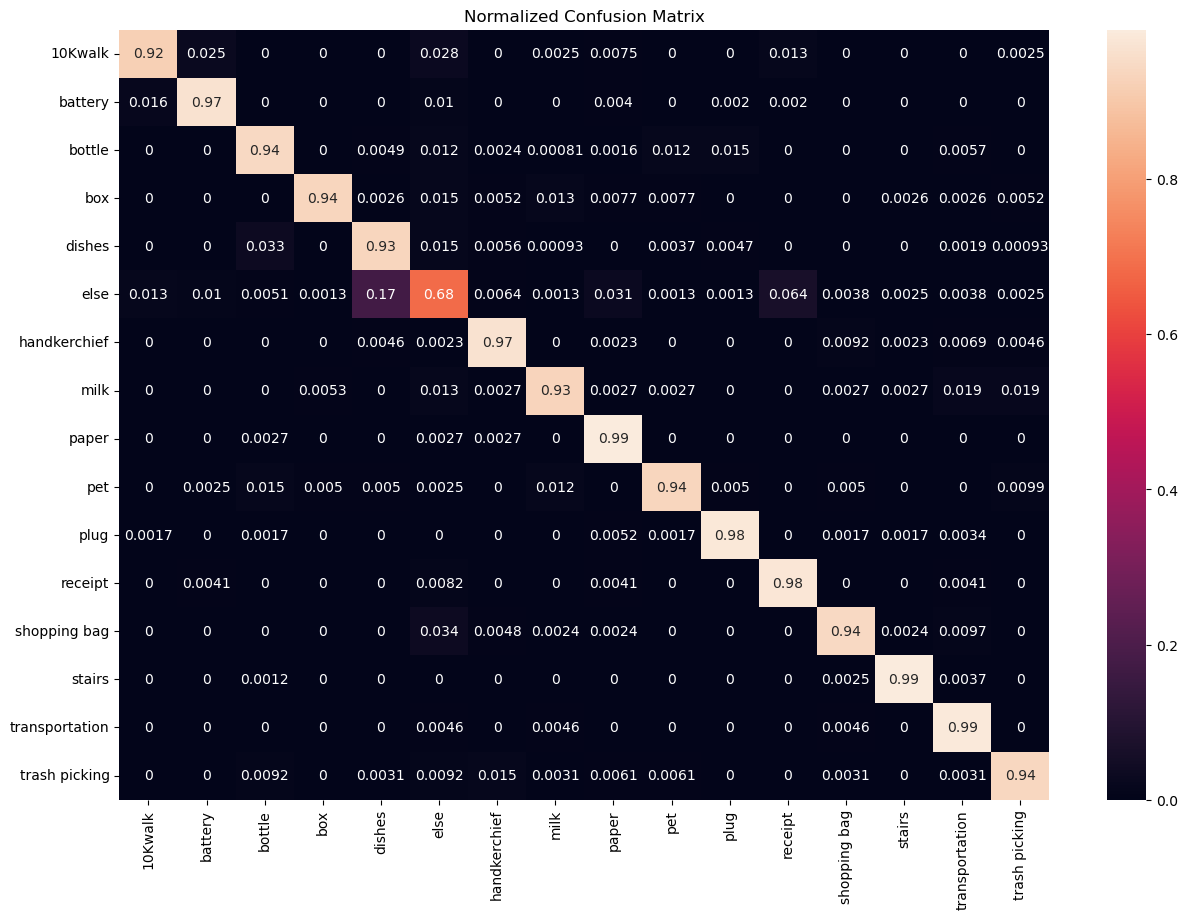

In [21]:
import seaborn as sns

test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
epoch_f1 = f1_score(test['label'], test['pred'], average='macro')
print(f'accuracy: {test_acc:.4f}')
print(f'f1_score: {epoch_f1:.4f}')

test_matrix = confusion_matrix(test['label'], test['pred'], normalize='true')
#test_matrix = confusion_matrix(test['label'], test['pred'])

plt.figure(figsize = (15,10))
sns.heatmap(test_matrix, 
            annot=True, 
            xticklabels = sorted(set(test['label'])), 
            yticklabels = sorted(set(test['label'])),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

#print(f'confusion_matrix \n-------------------------\n {test_matrix}')

In [23]:
test.to_csv('test_result/incep_res_0403.csv', index=False)

In [22]:
import json
import jsonlines
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import random

In [23]:
test['pred'].value_counts()

bottle            1229
dishes            1163
stairs             806
else               597
plug               593
battery            501
transportation     458
handkerchief       443
10Kwalk            411
pet                410
shopping bag       409
box                382
paper              374
milk               371
trash picking      325
receipt            288
Name: pred, dtype: int64

In [24]:
tmp_list = []
label = test[test.pred == 'else']

label.sort_values(by=['image_id'],ascending=True, inplace=True)
label.reset_index(inplace=True, drop=True)
tmp = label['image_id'].value_counts().index.sort_values()
label

/tmp/ipykernel_1475945/30508609.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label.sort_values(by=['image_id'],ascending=True, inplace=True)


,image_id,dir,label,pred
0,10Kwalk_1047.jpg,../Data/carbon_data/10Kwalk,10Kwalk,else
1,10Kwalk_1174.jpg,../Data/carbon_data/10Kwalk,10Kwalk,else
2,16583193231991658319380893.jpg,../Data/carbon_data/else/instance_spoon,else,else
3,16583311864571658331260534.jpg,../Data/carbon_data/else/instance_spoon,else,else
4,20220722_125118_HDR1658461897787.jpg,../Data/carbon_data/else/instance_spoon,else,else
...,...,...,...,...
592,wrap_990.jpg,../Data/carbon_data/dishes/wrap,dishes,else
593,wrap_995.jpg,../Data/carbon_data/dishes/wrap,dishes,else
594,양치컵 사용_063.jpg,../Data/carbon_data/bottle/toothcup/toothcup_852,bottle,else
595,양치컵 사용_140.jpg,../Data/carbon_data/bottle/toothcup/toothcup_852,bottle,else


In [ ]:
## show img status

back = 0
plt.figure(figsize=(16,500))
for i in range(len(label[200:400])):
    plt.subplot(100,4,i+1)
    if i % 4 == 0:
        plt.title(f"{(i+1+back)/4}")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
        
    path = label['dir'][i] + '/' + label['image_id'][i]
    try:
    # im_bgr = cv2.imread(path)
    # im_rgb = im_bgr[:, :, ::-1]
        temp = Image.open(path).convert("RGB")
        image = np.array(temp).copy()
        temp.close()

        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(label['image_id'][i], loc='left', fontsize=10)
    except:
        plt.xlabel(path, loc='left', fontsize=10)
        
plt.show()